# Computer Lab 1: k-NN classifier

## Exercise 1 – Synthetic dataset 
 
In this exercise, you will employ a synthetic dataset (file `synthetic.mat` in `/data/` folder), containing labelled training data and test data for two classes. Each example is 2-dimensional. 
 
**Task**: your task is to implement a k-NN classifier in Matlab, which calculates the probability that a given test example belongs to each class, and outputs a class label as the class with the highest  probability. You will evaluate the classifier performance computing the average classification accuracy (i.e. the fraction of test examples that have been classified correctly).
 
In particular, you should perform the following:
* Train a k-NN classifier for different values of k. 
* Compare accuracy on the training set and the test set. Calculating accuracy of the training  set means that you will have to classify each sample in the training set as if it were a test sample; one expects that classification of training samples will perform well, and this may also be used to validate your implementation. 
    * Accuracy is defined as the ratio between the number of test samples that are correctly classified, and the total number of test samples. 
* Identifying overfitting and underfitting in the obtained results. 
 
Note that, for this computer lab, you do not need to employ a validation set.

## k-NN Classifier: Theory

* Classification
    * This is a supervised learning approach, since there are some classes (2 in this particular case, then binary classification task) among them the algorithm must choose for each data input.
* k-NN: k-th Nearest Neighboors
    * Supervised learning algorithm
        * Within the test set, the algorithm identifies the k-nearest neighbors for each data point. Subsequently, it assigns the label to each data point in the test set based on the prevalent label among its k-nearest neighbors in the train set.
        * Metrics: to compute the nearest neighboors can be choosen any metrics to calculate "distance" between data points. Since in this case the data points are 2-dimensional, it has been used the Euclidean distance $d_{p_1,p_2}=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}$.
    * Non-parametric algorithm: no prior assumptions on data points distribution.

In [1]:
import matplotlib
import numpy as np
import os
import pandas as pd
import scipy.io
import seaborn as sns

# Plots
sns.set_context(
    'talk', rc = {
        'font.size': 12.0,
        'axes.labelsize': 10.0,
        'axes.titlesize': 10.0,
        'xtick.labelsize': 10.0,
        'ytick.labelsize': 10.0,
        'legend.fontsize': 10.0,
        'legend.title_fontsize': 12.0,
        'patch.linewidth': 2.0
        }
    ) # 'paper'

data_sets = ['Train', 'Test']

In [2]:
# Check current folder
os.getcwd()

'/'

In [16]:
data_path = '/Users/ernestocolacrai/Documents/GitHub/StatisticalLearning/data/synthetic.mat'

try:
    data = scipy.io.loadmat(data_path)
    print(f"Data ✓")
    print(f"Data Keys: {data.keys()}")
except:
    print(f"Not found data! ({data_path})")

Data ✓
Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'knnClassify2dTest', 'knnClassify2dTrain'])


In [17]:
data_df = {}

for d_type in data_sets:
    data_df[d_type] = pd.DataFrame(
        {'x': data[f'knnClassify2d{d_type}'][:,0],
        'y': data[f'knnClassify2d{d_type}'][:,1],
        'label': data[f'knnClassify2d{d_type}'][:,2]
        }
    )
    print(f"{d_type} ({len(data_df[d_type])} data points) ✓")
    print(f"{d_type} data types:\n{data_df[d_type].dtypes}\n")

data_df['Train'].head()

Train (100 data points) ✓
Train data types:
x        float64
y        float64
label    float64
dtype: object

Test (100 data points) ✓
Test data types:
x        float64
y        float64
label    float64
dtype: object



,x,y,label
0,2.1627,3.8666,1.0
1,2.0862,2.8266,1.0
2,1.8345,4.6970,1.0
3,2.6564,3.5323,1.0
4,3.9049,1.4013,1.0


In [18]:
# Check for NaN values
for d_type in data_sets:
    print(f"{d_type}:\n{data_df[f'{d_type}'].isna().sum(axis=0)}\n")

Train:
x        0
y        0
label    0
dtype: int64

Test:
x        0
y        0
label    0
dtype: int64



In [19]:
# Label = 1 or 2, then it is sufficient to use a 'int8' data type
for d_type in data_sets:
    data_df[d_type].label = data_df[d_type].label.astype('int8')

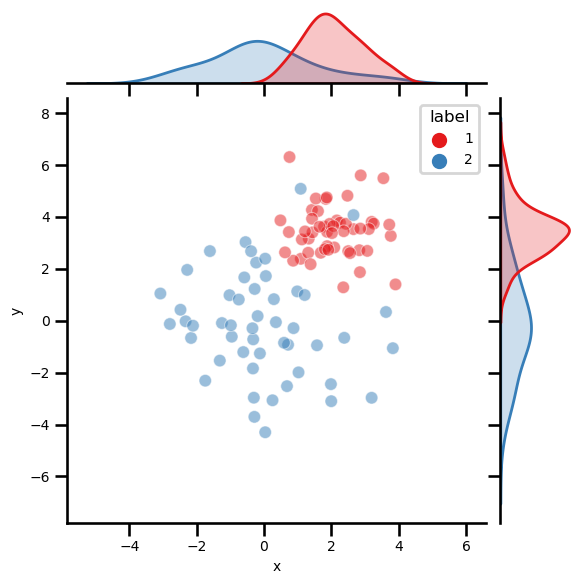

In [20]:
sns.jointplot(
    data=data_df['Train'], x='x', y='y',
    hue='label',
    palette='Set1', alpha=0.5
    )

In [21]:
type(data_df[d_type].loc[0][['x', 'y']].values) == np.ndarray

True

In [22]:
def euclidean(point1:np.ndarray, point2:np.ndarray) -> float:
    '''
    Euclidean metrics to compute the distance between two data points.
    Input: x:np.ndarray, y:np.ndarray
    Output: d:float
    '''
    return round(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 4)

In [23]:
euclidean(
    data_df['Train'].loc[0][['x', 'y']].values,
    data_df['Train'].loc[1][['x', 'y']].values
)

1.0428

* k-NN algorithm:
    * $\forall\ \mathbf{y}\in\mathcal{D}_{\text{TEST}}$
        * $\forall\ \mathbf{x}\in\mathcal{D}_{\text{TRAIN}}$
            * $d_{\mathbf{x},\mathbf{y}}=\sqrt{(y_1-x_1)^2 + (y_2 - x_2)^2}$
        * Select k-th points in train-set with the lowest distances associated to $\mathbf{y}$
        * Predicted label: $l_1 \dot{=}\frac{1}{k}\sum_{i=1}^k\mathbb{I}(l_{\mathbf{x}_i}=1)$
            * $l_{\mathbf{y}}=\begin{cases}1 & l_1 \geq \frac{k}{2} \\ 2 & \text{otherwise}\end{cases}$

**Problems**
* $|\mathcal{D}_{\text{TRAIN}}|=|\mathcal{D}_{\text{TEST}}|=N$
* $\forall \mathbf{y}\in\mathcal{D}_{\text{TEST}}$: $\mathcal{O}(N)$
    * $\mathbf{x}\in\mathcal{D}_{\text{TRAIN}}$: $\mathcal{O}(N)$
* Select k-th points with lowest distances: $\mathcal{O}(N)$ if data is stored in an array-like data structure
 * Overall: $\propto\mathcal{O}(N^2)$, maybe inefficient approach!

In [64]:
#for y in 
#data_df['Train'].loc[0].values[:-1]
M = len(data_df['Test'])
N = len(data_df['Train'])
data_df['Test']['classified'] = 0

k = 23

D = np.zeros([M, N], dtype=float)
E = np.zeros([M,k], dtype=int)

for i in np.arange(0, M, 1): # data points from test set
    for j in np.arange(0, N, 1): # data points from train set
        D[i][j] = euclidean(
            data_df['Test'].loc[i].values[:-1],
            data_df['Train'].loc[j].values[:-1]
            )
    E[i] = np.argsort(D[i])[:k]
    
    label1 = np.sum([int(data_df['Train'].loc[E[i][idx]].label == 1) for idx in np.arange(0,k)]) >= (k + 1) / 2
    label2 = np.sum([int(data_df['Train'].loc[E[i][idx]].label == 2) for idx in np.arange(0,k)]) >= (k + 1) / 2

    if label1:
        data_df['Test'].loc[i, 'classified'] = 1
    elif label2:
        data_df['Test'].loc[i, 'classified'] = 2
    else:
        data_df['Test'].loc[i, 'classified'] = 0

In [65]:
# Misclassification error
e = len(data_df['Test'][data_df['Test'].label != data_df['Test'].classified]) / M
print(f"Misclassification error: {e} ({e*100} %)")

Misclassification error: 0.13 (13.0 %)


In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=k)

# fitting the model
knn.fit(data_df['Train'][['x', 'y']].values, data_df['Train'].label.values)

# predict the response
pred = knn.predict(data_df['Test'][['x', 'y']].values)

# evaluate accuracy
print("accuracy: {}".format(accuracy_score(data_df['Test'].label.values, pred)))

accuracy: 0.87
